In [1]:
%pip install wandb
%pip install graphviz
%pip install torchviz
import wandb
wandb.login()#doesnt detect WANDB_NOTEBOOK_NAME on windows

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tetetoutou (simclr-doctoral-research). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="test-project", entity="simclr-doctoral-research")

In [3]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 512
}

In [4]:
import os
import wandb
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 10
batch_size = 512
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset_train = MNIST('./data', transform=img_transform, download=True,train = True)
dataset_test = MNIST('./data', transform=img_transform, download=True,train = False)

dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128))
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256,28 * 28), 
            nn.Tanh())
    def forward(self, x,only_encode=False):
        if only_encode:
            return self.encoder(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
auto_model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, auto_model.parameters()), lr=learning_rate, weight_decay=1e-5)#this line is needed
#to freeze gradients

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        output = auto_model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
    wandb.log({"loss": loss})

    wandb.watch(auto_model)
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))

pic = to_img(output.cpu().data)
save_image(pic, './mlp_img/image_final.png')


cuda
epoch [1/10], loss:0.1028
epoch [2/10], loss:0.0556
epoch [3/10], loss:0.0407
epoch [4/10], loss:0.0365
epoch [5/10], loss:0.0284
epoch [6/10], loss:0.0258
epoch [7/10], loss:0.0295
epoch [8/10], loss:0.0236
epoch [9/10], loss:0.0241
epoch [10/10], loss:0.0226


In [6]:
#test of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = auto_model(img)
    pic = to_img(output.cpu().data)
    save_image(pic, './mlp_img/image_test.png')
#accuracy of the autoencoder comparing input and output
loss_sum = 0
for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = auto_model(img)
    loss = criterion(output, img)
    loss_sum += loss.item()

print(loss_sum/len(test_data))


0.021432275604456662


In [7]:
from torchviz import make_dot
y = auto_model(img)
make_dot(y, params=dict(list(auto_model.named_parameters()))).render("torchviz", format="png")

'torchviz.png'

Now the encoder is going to be frozen

In [8]:
#freeze the encoder
# print(model.state_dict())

auto_model.encoder[0].weight.requires_grad = False
auto_model.encoder[0].bias.requires_grad = False
auto_model.encoder[2].weight.requires_grad = False
auto_model.encoder[2].bias.requires_grad = False


for name, param in auto_model.named_parameters():
    print(name, param.requires_grad)



# if param.requires_grad:print(name)
# for param in model.parameters():
#     print(param)
#     param.requires_grad = False


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True


In [9]:
#save the encoder
os.makedirs('./saved_models', exist_ok=True)
torch.save(auto_model.state_dict(), './saved_models/autoencoder.pth')

In [10]:
from linear_classifier import LinearClassifier

In [11]:
# #load the encoder
# model.load_state_dict(torch.load('./saved_models/autoencoder.pth'))
# #add a mlp to the encoder
# model.add_module('linear_classifier', linear_classifier())



In [12]:
#joined model
class JoinedModel(nn.Module):
    def __init__(self):
        super(JoinedModel, self).__init__()
        self.encoder = auto_model.encoder
        self.classifier = LinearClassifier()
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
joined_model = JoinedModel().to(device)

In [13]:
joined_model.encoder[0].weight.requires_grad = False
joined_model.encoder[0].bias.requires_grad = False
joined_model.encoder[2].weight.requires_grad = False
joined_model.encoder[2].bias.requires_grad = False

In [14]:
#verify weight are frozen

for name, param in joined_model.named_parameters():
    print(name, param.requires_grad)
print(joined_model.parameters)


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
classifier.fc1.weight True
classifier.fc1.bias True
classifier.fc2.weight True
classifier.fc2.bias True
<bound method Module.parameters of JoinedModel(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (classifier): LinearClassifier(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)>


In [15]:
#train the model on the labeled data
# model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, joined_model.parameters()), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    for data in dataloader:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        label = Variable(label).to(device)
        # ===================forward=====================
        output = joined_model(img)#This should only use the encoder
        loss = criterion(output, label)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.item()))
    wandb.log({"loss": loss})
    wandb.watch(joined_model)

epoch [1/10], loss:0.3214
epoch [2/10], loss:0.2304
epoch [3/10], loss:0.1203
epoch [4/10], loss:0.1935
epoch [5/10], loss:0.1093
epoch [6/10], loss:0.2432
epoch [7/10], loss:0.0467
epoch [8/10], loss:0.1000
epoch [9/10], loss:0.1401
epoch [10/10], loss:0.1347


In [16]:
#evaluate the model
loss_sum = 0
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    label = Variable(label).to(device)
    output = joined_model(img)
    loss = criterion(output, label)
    loss_sum += loss.item()


print(loss_sum/len(test_data))


0.10267309062182903


In [17]:
#

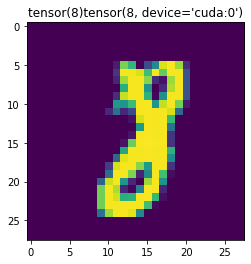

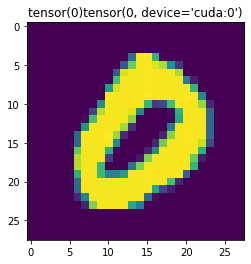

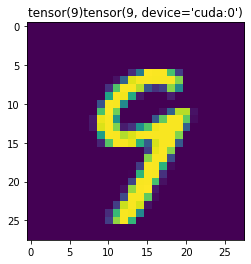

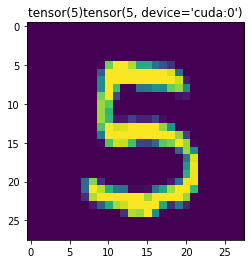

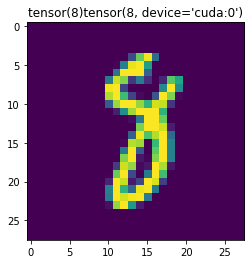

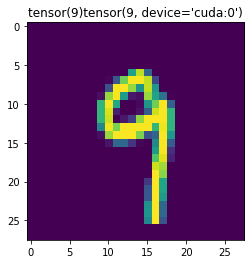

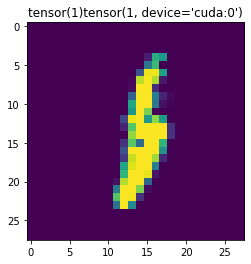

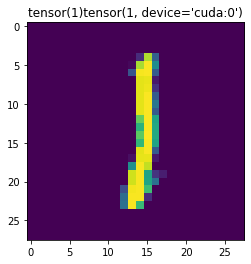

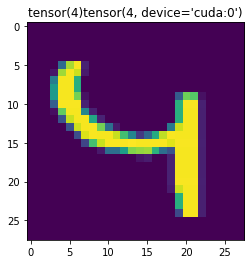

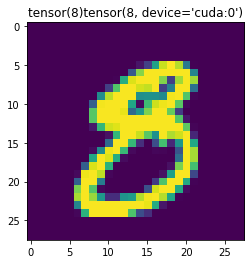

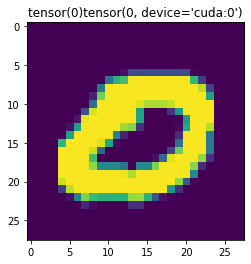

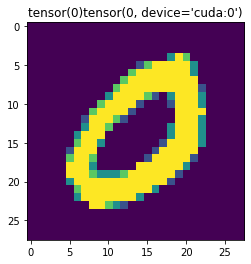

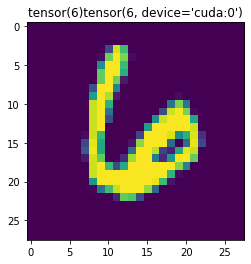

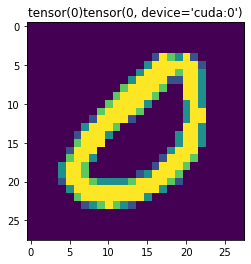

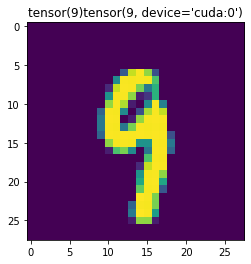

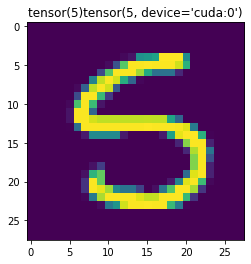

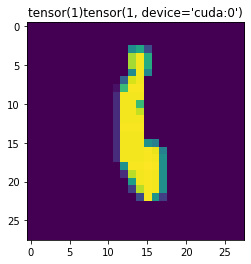

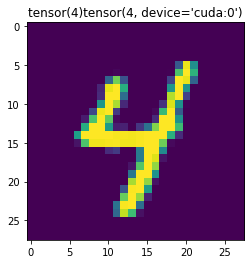

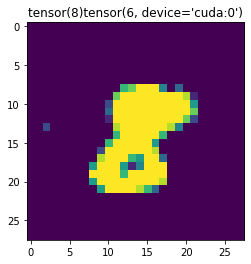

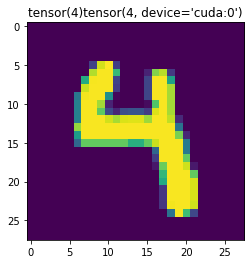

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# from fastai.vision.all import show_image
#show results of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    #label = Variable(label).to(device)
    output = joined_model(img)
    pic = to_img(img.cpu().data)
    # save_image(pic, './mlp_img/image_test.png')
    #show predicted label for the image
    #print(output.argmax(dim=1))
    #show the true label for the image
    #print(label)
    #show the image
    plt.imshow(np.transpose(img.view(img.size(0), 1, 28, 28).cpu().data[0], (1,2, 0)))
    #show the label corresponding to the image
    plt.title(str(label[0])+str(output.argmax(dim=1)[0]))
    plt.show()
    plt.close()

    

In [22]:
# evaluate model:
joined_model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_data:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        label = Variable(label).to(device)
        output = joined_model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print("accuracy: ", correct/total)

        

accuracy:  0.9688


In [20]:
#save the joined_model
torch.save(joined_model.state_dict(), './saved_models/joined_model.pth')
